In [2]:
import numpy as np
import os
import gzip
import random
import time
import signal

import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'hot'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = ""
ddir = "../data/books/witcher_rus/"
for fn in sorted(os.listdir(ddir)):
    if fn.endswith(".gz"):
        with gzip.open(ddir + fn, "rb") as f:
            data += f.read().decode("utf-8").replace("\r", "")
charset = sorted(set(data))
print(charset)
print("%s chars, %s unique" % (len(data), len(charset)))
chidx = {ch: i for i, ch in enumerate(charset)}
chvec = {ch: np.array([chidx[ch] == i for i in range(len(charset))], dtype=np.float64) for ch in charset}

['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
5088376 chars, 140 unique


In [4]:
#charset = sorted(set("".join(charset).lower()))
#print(charset)
#chidx = {ch: i for i, ch in enumerate(charset)}
#chvec = {ch: np.array([chidx[ch] == i for i in range(len(charset))], dtype=np.float64) for ch in charset}
#for ch in charset:
#    if ch.islower():
#        chidx[ch.upper()] = chidx[ch]
#        chvec[ch.upper()] = chvec[ch]

In [5]:
seqlen = 100
sequences = []
for i in range(0, len(data), seqlen):
    in_seq, out_seq = data[i:i+seqlen], data[i+1:i+seqlen]
    sequences.append((
        [chvec[ch] for ch in in_seq],
        [chvec[ch] for ch in out_seq]
    ))

In [6]:
def tanh_deriv(x):
        return 1/np.cosh(x)**2

def sigmoid(x):
    ex = np.exp(x)
    return ex/(ex + 1)

def sigmoid_deriv(x):
    ex = np.exp(x)
    return ex/(ex + 1)**2
    
def softmax(y):
    y = y - np.max(y)
    ey = np.exp(y)
    return ey/np.sum(ey)

def cross_entropy_loss(y, r):
    return -np.log(np.dot(y, r))

In [7]:
class Cell:
    def __init__(self, sx, sh, sy, mag=1e-1):
        self.sizes = (sx, sh, sy)
        layer_sizes = [(sx, sh), (sh, sh), (sh, sy)] # W_xh, W_hh, W_hy
        self.params = [ mag*np.random.randn(*s) for s in layer_sizes]
    
    def newgrad(self):
        return [np.zeros_like(v) for v in self.params]
    
    def newstate(self):
        return np.zeros(self.sizes[1], dtype=np.float64)
    
    def step(self, h, x, mem=False):
        W_xh, W_hh, W_hy = self.params
        v = np.dot(x, W_xh) + np.dot(h, W_hh)
        a = np.tanh(v)
        y = np.dot(a, W_hy)

        if mem:
            m = [x, h, v, a, y]
        else:
            m = None
        return a, softmax(y), m
    
    def backprop_step(self, grad, eh, m, ey):
        W_xh, W_hh, W_hy = self.params
        dW_xh, dW_hh, dW_hy = grad
        x, h, v, a, y = m
        
        dW_hy += np.outer(a, ey)
        ea = np.dot(W_hy, ey) + eh
        ev = ea*tanh_deriv(v)
        dW_xh += np.outer(x, ev)
        dW_hh += np.outer(h, ev)
        eh = np.dot(W_hh, ev)
        
        return eh
    
    def learn(self, grad, learning_rate, adagrad=None, rmsprop=0):
        if adagrad is None: 
            for W, dW in zip(self.params, grad):
                W -= learning_rate*dW
        else:
            for W, dW, aW in zip(self.params, grad, adagrad):
                aW += dW**2
                if rmsprop != 0:
                    aW *= (1 - rmsprop)
                W -= learning_rate*dW/np.sqrt(aW + 1e-8)

In [8]:
class LSTMCell:
    def __init__(self, sx, sh, sc, sy, mag=1e-1):
        self.sizes = (sx, sh, sc, sy)
        layer_sizes = [
            (sx, sh), (sh, sc), (sh, sy), # W_xh, W_hc, W_hy
            (sh, sc), (sh, sc), (sh, sc) # W_f, W_i, W_o
        ]
        self.params = [ mag*np.random.randn(*s) for s in layer_sizes]
    
    def newgrad(self):
        return [np.zeros_like(v) for v in self.params]
    
    def newstate(self):
        return (np.zeros(self.sizes[1], dtype=np.float64), np.zeros(self.sizes[2], dtype=np.float64))
    
    def step(self, hc, x, mem=False):
        h, c = hc
        W_xh, W_hc, W_hy, W_f, W_i, W_o = self.params
        
        x_w = np.dot(x, W_xh)
        xh = x_w + h
        
        f_w = np.dot(xh, W_f)
        f_s = sigmoid(f_w)
        c_m = f_s*c
        
        i_w = np.dot(xh, W_i)
        i_s = sigmoid(i_w)
        hc_w = np.dot(xh, W_hc)
        hc_t = np.tanh(hc_w)
        hc_m = i_s*hc_t
        c_a = c_m + hc_m
        
        o_w = np.dot(xh, W_o)
        o_s = sigmoid(o_w)
        ch_t = np.tanh(c_a)
        ch_m = o_s*ch_t
        
        y = np.dot(ch_m, W_hy)
        
        if mem:
            m = [
                x, xh, c,
                f_w, f_s,
                i_w, i_s, hc_w, hc_t,
                o_w, o_s, c_a, ch_t,
                ch_m
            ]
        else:
            m = None
        return (ch_m, c_a), softmax(y), m
    
    def backprop_step(self, grad, ehc, m, ey):
        eh, ec = ehc
        W_xh, W_hc, W_hy, W_f, W_i, W_o = self.params
        dW_xh, dW_hc, dW_hy, dW_f, dW_i, dW_o = grad
        x, xh, c, f_w, f_s, i_w, i_s, hc_w, hc_t, o_w, o_s, c_a, ch_t, ch_m = m
        
        dW_hy += np.outer(ch_m, ey)
        ech_m = np.dot(W_hy, ey) + eh
        ech_t = ech_m*o_s
        ec_a = ech_t*tanh_deriv(c_a) + ec
        
        eo_s = ech_m*ch_t
        eo_w = eo_s*sigmoid_deriv(o_w)
        dW_o += np.outer(xh, eo_w)
        exh_o = np.dot(W_o, eo_w)
        
        ehc_t = ec_a*i_s
        ehc_w = ehc_t*tanh_deriv(hc_w)
        dW_hc += np.outer(xh, ehc_w)
        exh_hc = np.dot(W_hc, ehc_w)
        
        ei_s = ec_a*hc_t
        ei_w = ei_s*sigmoid_deriv(i_w)
        dW_i += np.outer(xh, ei_w)
        exh_i = np.dot(W_i, ei_w)
        
        ef_s = ec_a*c
        ef_w = ef_s*sigmoid_deriv(f_w)
        dW_f += np.outer(xh, ef_w)
        exh_f = np.dot(W_f, ef_w)
        
        ec_i = ec_a*f_s
        exh = exh_f + exh_i + exh_hc + exh_o
        
        dW_xh += np.outer(x, exh)
        
        return (exh, ec_i)
    
    def learn(self, grad, learning_rate, adagrad=None, rmsprop=0):
        if adagrad is None: 
            for W, dW in zip(self.params, grad):
                W -= learning_rate*dW
        else:
            for W, dW, aW in zip(self.params, grad, adagrad):
                aW += dW**2
                if rmsprop != 0:
                    aW *= (1 - rmsprop)
                W -= learning_rate*dW/np.sqrt(aW + 1e-8)

In [9]:
def train(net, in_seq, out_seq, learning_rate, h=None, adagrad=None, rmsprop=0, clip=5):
    seqlen = min(len(in_seq), len(out_seq))
    
    # forward pass
    loss = 0.0
    memory = []
    if h is None:
        h = net.newstate()
    for x, r in zip(in_seq, out_seq):
        h, y, m = net.step(h, x, mem=True)
        memory.append((m, y, r))
        loss += cross_entropy_loss(y, r)
    loss /= seqlen
    
    # error backpropagation
    grad = net.newgrad()
    eh = net.newstate()
    for m, y, r in reversed(memory):
        net.backprop_step(grad, eh, m, y - r)
    for dW in grad:
        dW /= seqlen
        np.clip(dW, -clip, clip, out=dW) # mitigate exploding gradient
    
    # gradient descent
    net.learn(grad, learning_rate, adagrad=adagrad, rmsprop=rmsprop)

    return loss, h

In [10]:
class TrainingContext:
    def __init__(self, name, **params):
        self.name = name
        
        inout_size = params["charset_size"]
        if params.get("lstm", False):
            self.net = LSTMCell(inout_size, params["hidden_size"], params["cell_size"], inout_size)
        else:
            self.net = Cell(inout_size, params["hidden_size"], inout_size)
        self.h = self.net.newstate()
        
        self.loss = None #-np.log(1.0/inout_size)*params["sequence_length"]
        self.loss_history = []
        
        self.adagrad = self.net.newgrad() if params.get("adagrad", False) else None
        self.params = params
        
    def train(self, in_seq, out_seq):
        loss, self.h = train(
            self.net, in_seq, out_seq,
            self.params["learning_rate"],
            adagrad=self.adagrad,
            rmsprop=self.params.get("rmsprop", 0)
        )
        if self.loss is None:
            self.loss = loss
        else:
            self.loss = 0.99*self.loss + 0.01*loss
    
    def sample(self, x, size):
        out = ""
        h = self.h
        for i in range(size):
            h, y, _ = self.net.step(h, x)
            ch = np.random.choice(charset, p=y)
            x = chvec[ch]
            out += ch
        return out

In [11]:
params = {
    "hidden_size": 30,
    "cell_size": 30,
    "charset_size": len(charset),
    "sequence_length": seqlen,
    "learning_rate": 1e-1
}
ctx_rnn = TrainingContext("RNN", **params, adagrad=True)
ctx_lstm = TrainingContext("LSTM", lstm=True, **params, adagrad=True)

In [12]:
epoch = 0
iseq = 0
seq_labels = []

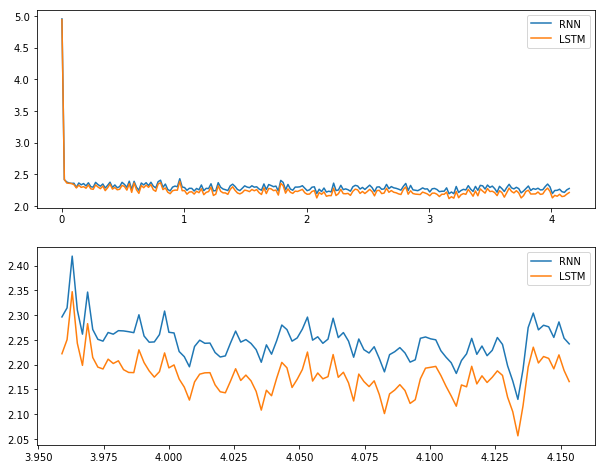

stop


In [14]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

while not done:
    for ctx in [ctx_rnn, ctx_lstm]:
        ctx.train(*sequences[iseq])
    
    if iseq % 100 == 0:
        clear_output(wait=True)
        seq_labels.append(epoch + iseq/len(sequences))
        start = 1
        
        for ctx in [ctx_rnn, ctx_lstm]:
            ctx.loss_history.append(ctx.loss)
           
        plt.subplot(2, 1, 1)
        for ctx in [ctx_rnn, ctx_lstm]:
            plt.plot(seq_labels[::10], ctx.loss_history[::10], label=ctx.name)
        plt.legend()
        
        plt.subplot(2, 1, 2)
        for ctx in [ctx_rnn, ctx_lstm]:
            plt.plot(seq_labels[-100:], ctx.loss_history[-100:], label=ctx.name)
        plt.legend()
        
        plt.show()
        
    iseq += 1
    if iseq >= len(sequences):
        iseq = 0
        epoch += 1

print("stop")

In [15]:
for ctx in [ctx_rnn, ctx_lstm]:
    print("%s: '%s'" % (ctx.name, ctx.sample(sequences[iseq][1][-1], 100)))

RNN: '

- зап. Триклюся и пелают.
- Даз- у, Maidh?

Герял гре нех суметудать я товомился.

- Нукая пртоква'
LSTM: '

- Расклет а былдать знаая насовывался бумеными ниберину, закребулопакая Жя чебяла мнема Людерь в к'
